This problem was done in cooperation between Aaron Maurer and Stanley Guan.

In [3]:
# Imports
import json
import re
import numpy as np
import numpy.linalg as nplin
from __future__ import division
import matplotlib.pyplot as plt
import string
import operator
from time import time
import requests
from operator import itemgetter
%matplotlib inline

# Am I working on AWS?
AWS = False

# Check Spark is working
print sc 

In [4]:
# load data
if AWS:
    rawTweets = "s3n://stat-37601/tweets.json"
else:
    rawTweets = "data/tweets.json"
    emoticionsPath = 'data/wikipedia_emoticions.txt'


tweets = sc.textFile(rawTweets).map(json.loads).cache()

#### (a) Generating features
The general concept is that we are identifying a tweet by presence of words/emoticions/punctuation that seems like it could be predictive of positive sentiment (as identified by the data set). The order is ignored. To get a fairly clean list of features though, we do a lot of text cleaning (which truthfully doesn't seem to make much of a difference):
- Get rid of times
- Standardize groups of 3 or more periods to an ellipsis
- Standardize stuff like '?!?!?!' to '!?'
- Turn multiple ? or ! into just one
- Seperate punctuation from words ('goodbye.' => 'goodbye','.'
- Get rid of twitter handles
- Standardize words to not having an apostrophe (doesn't => doesnt)
- Remove URLS
- make words uniformly lower case
- single out common emoticions into their own words
- remove common neutral words like prepositions

We then count up how often each of the remaining words are present accross all the tweets, and build a dictionary out of those that occur in at least 250 tweets. We then represent a tweet as a list of which items in this dictionary are present in the tweet.

In [5]:
# Symbols we want delinated by themselves as potential words for our dictionary
emoticonsFile = open(emoticionsPath, "r") # I nabbed a list of common emoticions from wikipedia
emoticons = emoticonsFile.read().split()
emoticonsFile.close()

delination = emoticons
delination_re = re.compile('('+ '|'.join(map(re.escape, delination)) + ')') # sticks the entire thing in a regular expression 

# words to ignore
stop = set(['the', 'and', 'you', 'your', 'for', 'por', 'que', 'las', 'los', 'les',\
       'una', 'del', 'este', 'usted', 'para', 'con', 'this', 'that', 'was', 'have', 'like',\
       'would', 'could', 'should', 'will', 'can', 'shall', 'just', 'all', 'it', 'its', 'per'])
eng_stop = set(['i', 'me', 'my', 'myself', 'we', 'our', \
             'ours', 'ourselves', 'you', 'your', 'yours', \
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', \
             'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', \
             'themselves', 'what', 'which', 'who', 'whom', 'this', \
             'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
             'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',\
             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', \
             'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',\
             'by', 'for', 'with', 'about', 'against', 'between', 'into', \
             'through', 'during', 'before', 'after', \
            'above', 'below', 'to', 'from', 'up', 'down', 'in',\
            'out', 'on', 'off', 'over', 'under', 'again', 'further', \
            'then', 'once', 'here', 'there', 'when', 'where', 'why', \
            'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',\
            'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', \
            'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', \
            'just', 'don', 'should', 'now'])
spa_stop = set()
punc_stop = set(['.','(',')',"'",'"',',',';',':','-'])
all_stop = stop|eng_stop|spa_stop|punc_stop

# word processor function - should keep hashtags as is
def splitter(s,delin_re=delination_re,ignore=all_stop):
    s = re.sub('[12]?[0-9]:[0-5][0-9]',' ',s) # get rid of times (they don't play well with the emoticions)
    s = re.sub('\.{3,}',' ... ',s)            # standardize elipses 
    s = re.sub('\?![\?!]*|!\?[\?!]*',' !? ',s) # standardize ?!?!?!
    s = re.sub('!+','!',s)                    # standardize to single !
    s = re.sub('\?+','?',s)                   # standarize to single ?
    s = re.sub('([a-zA-z]{2,})([.,;:\?!\)]+)(\s|$)','\g<1> \g<2> ',s) # single out punctuation
    s = re.sub(' \((\w{2,})',' \g<1>',s)      # single out ( at start of word
    s = re.sub('@\w+',' ',s)                  # get rid of usernames
    s = re.sub("([a-zA-Z])'([a-zA-Z])","\g<1>\g<2>",s) # standardize to no apostrophe
    s = re.sub('(?!http://)www\.\S+|http://\S+','',s) # get rid of urls
    s = delin_re.sub(' \g<1> ',s).lower()
    return list(set([w for w in s.split() if w not in ignore]))

# a few examples of cleaned tweets
splitter(':):(:-)')
for i, tweet in enumerate(tweets.take(10)):
    print '%d: "%s" CHANGES TO ' % (i,tweet['text'])
    print [str(w) for w in splitter(tweet['text'])]

0: "is so sad for my APL friend............." CHANGES TO 
['...', 'friend', 'apl', 'sad']
1: "I missed the New Moon trailer..." CHANGES TO 
['new', '...', 'missed', 'trailer', 'moon']
2: "omg its already 7:30 :O" CHANGES TO 
[':o', 'already', 'omg']
3: ".. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..." CHANGES TO 
['ive', 'since', '..', 'suposed', 'gunna', 'crown', 'cry', 'sooo', '11..', '30mins', 'dentist', '2', 'im', 'omgaga', 'put', 'get', '...']
4: "i think mi bf is cheating on me!!!       T_T" CHANGES TO 
['!', 'bf', 'cheating', 'mi', 'think', 't_t']
5: "or i just worry too much?" CHANGES TO 
['much', '?', 'worry']
6: "Juuuuuuuuuuuuuuuuussssst Chillin!!" CHANGES TO 
['!', 'chillin', 'juuuuuuuuuuuuuuuuussssst']
7: "Sunny Again        Work Tomorrow  :-|       TV Tonight" CHANGES TO 
['tv', 'work', 'sunny', 'tonight', ':-|', 'tomorrow']
8: "handed in my uniform today . i miss you already" CHANGES TO 
['already'

In [14]:
# Form dictionary
cutoff = 250 # number of times word must appear accross all tweets
tweets_d = tweets.flatMap(lambda x: splitter(x['text']))\
    .map(lambda x: (x,1))\
    .reduceByKey(lambda a,b: a+b)\
    .filter(lambda x: x[1]>=cutoff)\
    .collectAsMap()
    
wordDict = dict(zip(tweets_d.keys(),range(len(tweets_d)))) # this will map each word to a number
lenDict = len(wordDict)
print '%d features in model' % lenDict

4389 features in model


In [8]:
sortedDict = sorted(tweets_d.items(),key=itemgetter(1))

# look at the most and least common words in our dictionary
n = 10
print "Most and least common items in dictionary"
for i,(w,f) in enumerate(sortedDict[-n:-1],start=1):
    print '%d: "%s" appeared %d times' % (i,w,f)
    
for i,(w,f) in enumerate(sortedDict[:n],start=1):
    print '%d: "%s" appeared %d times' % (len(sortedDict)-i,w,f)

Most and least common items in dictionary
1: "today" appeared 62996 times
2: "dont" appeared 63557 times
3: "go" appeared 69333 times
4: "day" appeared 77456 times
5: "get" appeared 78192 times
6: "good" appeared 82800 times
7: "?" appeared 137386 times
8: "im" appeared 160864 times
9: "..." appeared 227706 times
4388: "roommate" appeared 250 times
4387: "vibes" appeared 250 times
4386: "urban" appeared 250 times
4385: "cranky" appeared 250 times
4384: "stalking" appeared 250 times
4383: "stats" appeared 250 times
4382: "ai" appeared 250 times
4381: "muffin" appeared 251 times
4380: "thrilled" appeared 251 times
4379: "haters" appeared 251 times


In [9]:
# map job to generate features on all tweets
def feature_mapper(x,dictionary=wordDict):
    txt = splitter(x['text'])
    features = [dictionary[w] for w in txt if w in dictionary]
    # want to convert this to integers 0, 1 or -1 for unknown
    try:
        lab = int(x['label'])
    except:
        lab = -1
    return (x['id'], lab, features)

tweets_featured = tweets.map(feature_mapper).cache()

In [10]:
# spark doesn't seem to have an efficient way to loop through all items, so we stick everything in a list
tweetList = tweets_featured.collect()

#### (b) Stochastic gradient descent
We fit a logit on the features of the tweet using stochastic gradient descent. The SGDlogit class contains all the methods necessary to fit, evaluate, and plot the model. The important imputs are the learning rate eta and the coefficient on the L2 penalty.

Here we try a series of fits. In the graphs, the blue line is a running in sample error rate while fitting the model (over the previous 100k tweets), while the red line is the end out of sample rate.

In [167]:
class SGDlogit:    
    def __init__(self,dat,nFeatures, etaConst, etaForm, reg):
        assert etaForm in ("const", "inv", "root")       
        self.data = dat              # data set to fit on\n        
        self.nFeatures = nFeatures   # number of features in model (size of dictionary)       
        self.etaConst = etaConst     # constant component used to calculate eta       
        self.etaForm = etaForm       # denotes how eta shrinks over time        
        self.reg     = reg           # lambda or coefficient on L2 norm        
        self.n       = len(dat)      # size of data set        
        self.b       = 0             # model intercept        
        self.beta    = np.zeros(nFeatures) # coefficients on features        
        self.errorRates = []         # observed error rates while fitting        
        self.counter = 0             # how many observations has the model been fit on (may be repeates)        
        self.nErrors = 0             # total number of prediction errors 
        self.passes  = 0             # how many times has the model gone through the data set        
        self.time    = 0             # how long have we spent fitting the model?        
        self.ERfreq  = 1000          # how often do we calculate the error
        self.missingPred = {}        # dictionary of predictions for ids missing label        
        self.missingError = None     # error rate in ids missing labels        
        self.passes  = 0             # how many times have we gone through the data set?

    # gets eta
    def getEta(self):
        if   self.etaForm == "const": return self.etaConst
        elif self.etaForm == "root" : return self.etaConst / (self.counter ** 0.5)
        return                               self.etaConst / self.counter
                                                              
    # output a nice string representing eta
    def expressEta(self):
        if   self.etaForm == "const": return str(self.etaConst)
        elif self.etaForm == "root" : return "%s / root(t)" % self.etaConst
        return                               "%s / t" % self.etaConst
        
    # predicts probability based on features
    def pi(self,features) :
        exponent = -self.b
        for w in features:
            exponent -= self.beta[w] 
        return  1 / (1 + np.exp(exponent))
    
    # gives prediction
    def predict(self,features):
        return int(round(self.pi(features)))
    
    # trains model
    def train(self,nPasses):
        start = time()
        for p in range(nPasses):
            for id, lab, features in self.data:
                # probability and prediction
                pred = self.predict(features)
                # update prection unlabelled data
                if lab == -1: 
                    self.missingPred[id] = pred
                # only want to fit based on observations with labels
                else :
                    self.counter += 1
                    # count up errors
                    if lab != pred: 
                        self.nErrors += 1
                    if self.counter % self.ERfreq == 0:
                        self.errorRates.append(self.nErrors / self.counter)

                    # update coefficients
                    eta = self.getEta()
                    self.beta = self.beta * (1 - 2 * self.reg * eta) # apply regularization, except to intercept
                    multiplier = eta * (lab - self.pi(features))
                    self.b += multiplier
                    for w in features:
                        self.beta[w] += multiplier
        self.time += time()-start
        self.passes += nPasses   

    # query the oracle on the unlabeled observations
    def getUnlabelledError(self):
        packed_results = "\n".join(["{0} {1}".format(key, str(value).strip()) for key, value in self.missingPred.items()])
        got = requests.post("http://lsda.cs.uchicago.edu:5000", files={"results": packed_results}).json()
        self.missingError = 1 - got['correct'] / got['of']
    
    # plot the error rate
    def plotError(self,givenPlot):
        mult = self.ERfreq/1e6
        length  = len(self.errorRates)
        xmaximum = mult*length
        givenPlot.plot(mult*(1+np.arange(length)), self.errorRates)
        givenPlot.set_title('eta = ' + self.expressEta() + '; lambda = ' + str(self.reg))
        givenPlot.axhline(y=self.missingError,xmin=0,xmax=xmaximum,color="red")
        givenPlot.set_xlim(0,xmaximum)
        givenPlot.set_xlabel("Tweets Seen, Mil")
        givenPlot.set_ylabel("Error Rate")
        givenPlot.set_ylim(0,.6)
    
    # train the model and calculate the error
    def doAll(self,nPasses):
        self.train(nPasses)
        self.getUnlabelledError()
        return(self)

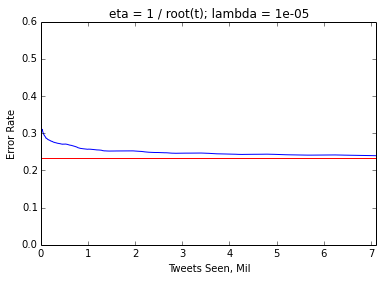

In [169]:
# try the aggresive learning rate 1/root(t)
passes = 5
fit = SGDlogit(tweetList, lenDict, 1, "root", .00001).doAll(passes)
f,subplts = plt.subplots(1,1)
fit.plotError(subplts)

This model seems to converge in one pass through the data, and the in sample error rate is about the same as the out of sample error rate.

In [170]:
# Lets look at what coefficients are largest and smallest
wordBetas = sorted(zip(tweets_d.keys(),fit.beta),key=itemgetter(1),reverse=True)
n = 10
print "Rank of Coefficients"
for i,(w,f) in enumerate(wordBetas[:n],start=1):
    print '%d: "%s" has a coefficient of %.3f' % (i,w,f)
    
for i,(w,f) in enumerate(wordBetas[-n:-1],start=1):
    print '%d: "%s" has a coefficient of %.3f' % (len(sortedDict)-n+i+1,w,f)

Rank of Coefficients
1: "thank" has a coefficient of 1.641
2: "welcome" has a coefficient of 1.615
3: "thanks" has a coefficient of 1.418
4: "smile" has a coefficient of 1.252
5: "glad" has a coefficient of 1.250
6: "excited" has a coefficient of 1.220
7: "#followfriday" has a coefficient of 1.189
8: "wait" has a coefficient of 1.171
9: "awesome" has a coefficient of 1.144
10: "yay" has a coefficient of 1.101
4381: "wish" has a coefficient of -1.677
4382: "unfortunately" has a coefficient of -1.718
4383: "hate" has a coefficient of -1.741
4384: "hurts" has a coefficient of -1.770
4385: "missing" has a coefficient of -1.935
4386: "sick" has a coefficient of -1.954
4387: "miss" has a coefficient of -2.099
4388: "poor" has a coefficient of -2.106
4389: "sucks" has a coefficient of -2.132


The coefficients seem to make sense.

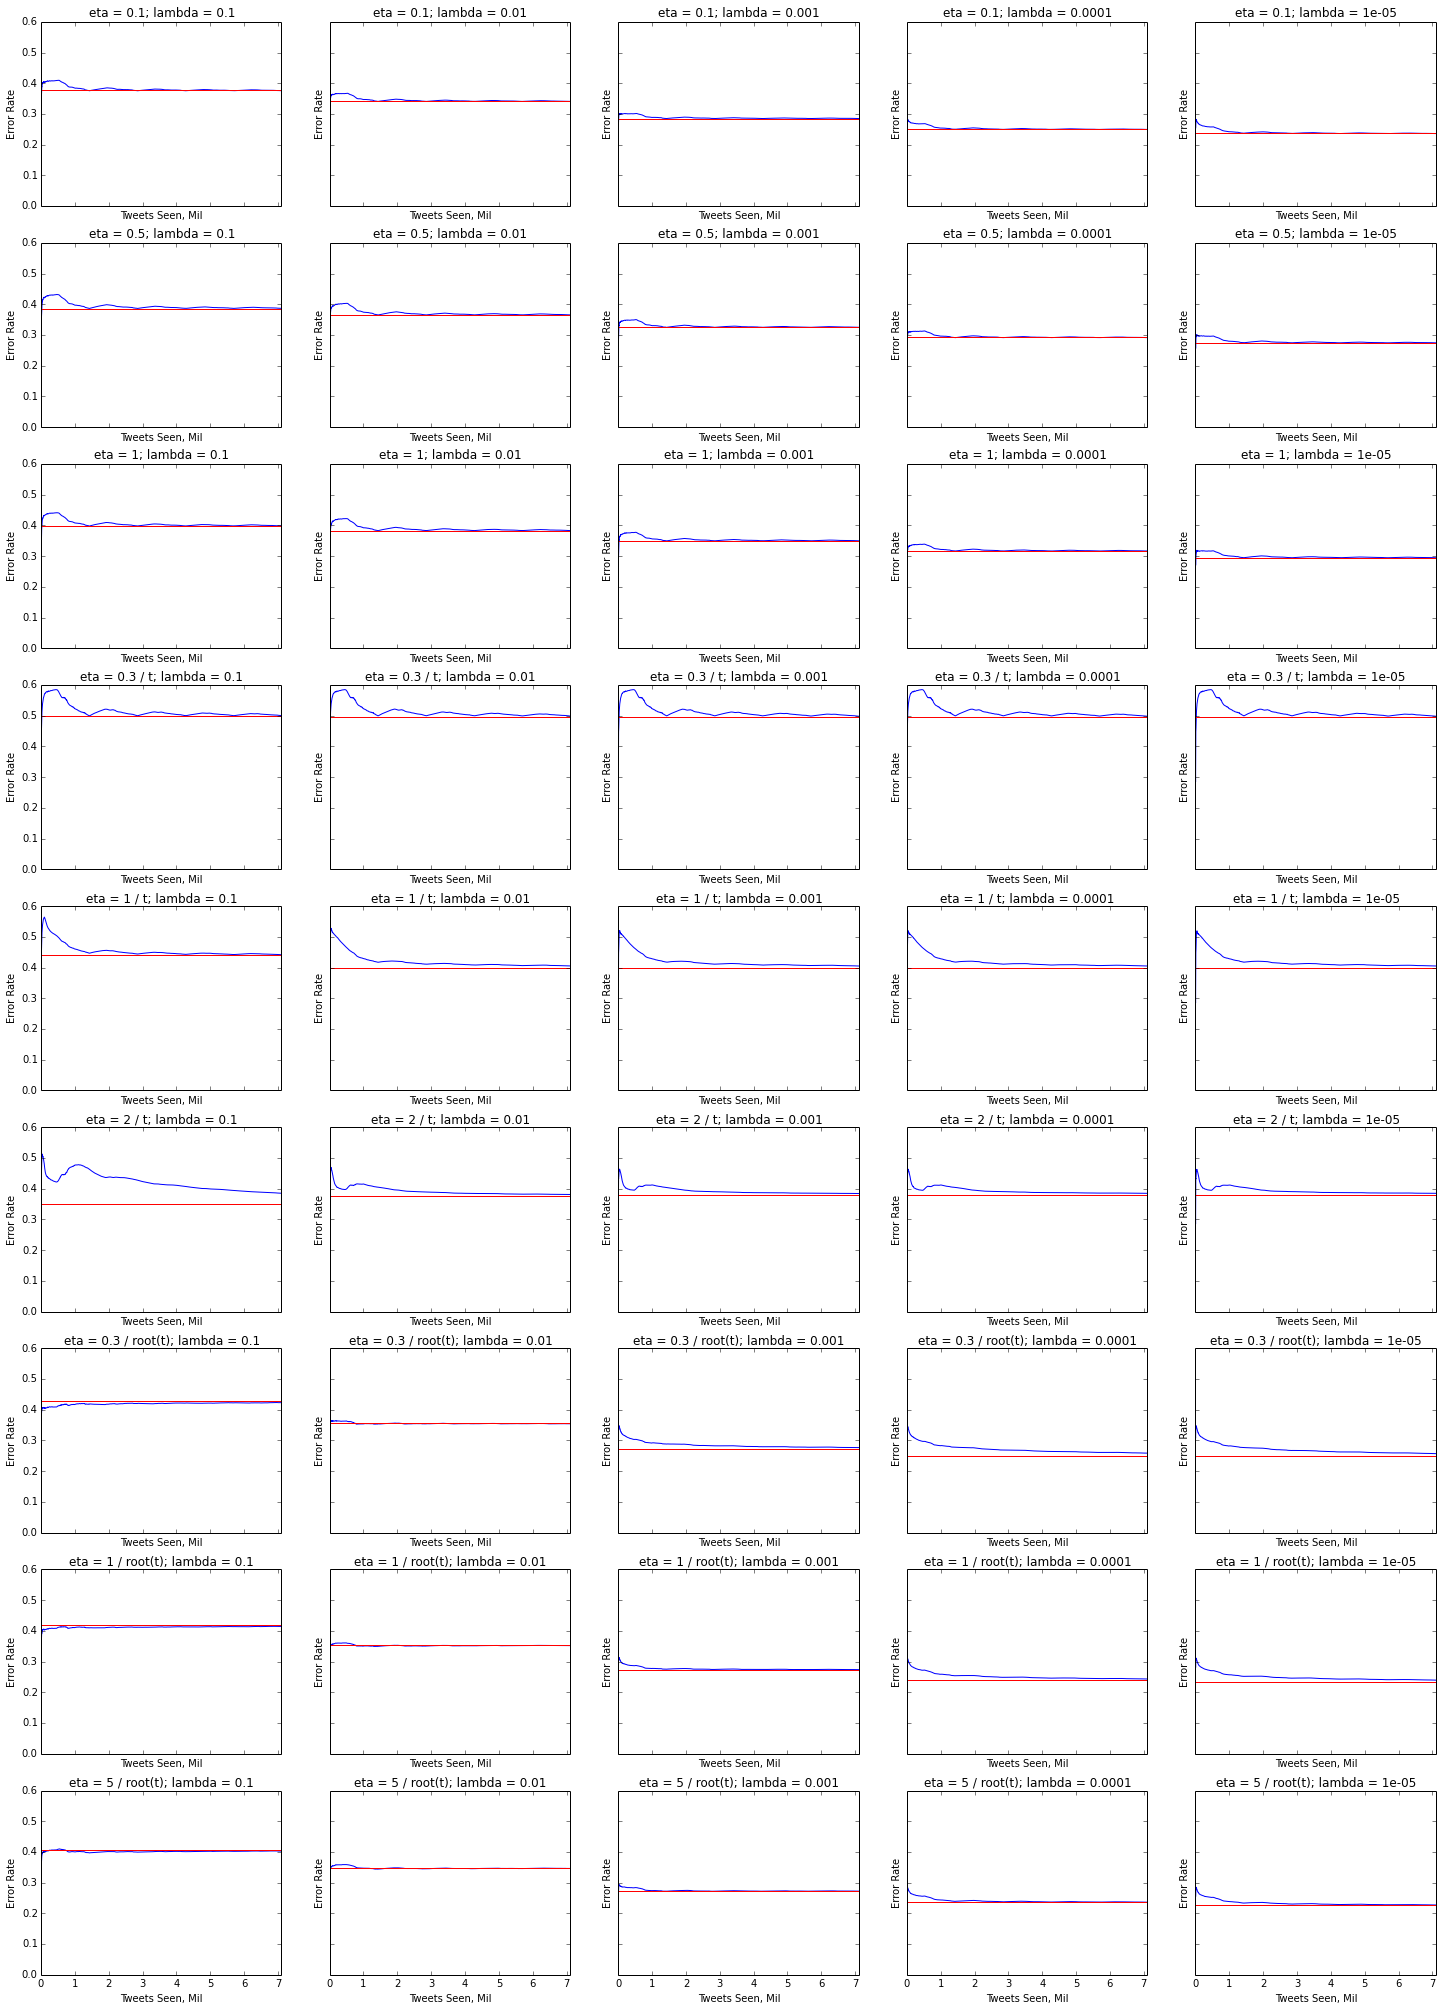

In [171]:
# now, compare for a whole bunch of values
etas = [(0.1, "const"), (0.5, "const"), (1, "const"), (0.3, "inv"), (1, "inv"), (2, "inv"), (0.3, "root"), (1, "root"), (5, "root")]
lambdas = [1e-1,1e-2,1e-3,1e-4,1e-5]
passes = 5

models = [[None for x in range(len(lambdas))] for x in range(len(etas))] 
f,subplts = plt.subplots(len(etas),len(lambdas), sharex='col', sharey='row')
f.set_size_inches(25,35)
for c, lam in enumerate(lambdas):
    for r, (eta, etaForm) in enumerate(etas):
        models[r][c] = SGDlogit(tweetList, lenDict, eta, etaForm, lam).doAll(passes)
        models[r][c].plotError(subplts[r,c])

We seem to get our best fit with the aggressive learning rate (5/root(t) does best) and fairly low regularization (lambda=1e-5). The conservative learning rate seem to perform the worst. Also, we don't seem to have much of a problem ever with over-fitting, even with a very small regularization coefficient, suggesting that we might do well to include more/ more sophisticated features.